In [1]:
# Import the required packages
import numpy as np
# from numpy.linalg import svd as svd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
# from collections import OrderedDict
import matplotlib.pyplot as plt
import time

# Define plot font sizes
label_font = 18
title_font = 24
legend_font = 12


# RNN Model Class - Classical Conditioning

In [2]:
class Drosophila_RNN(nn.Module):
    def __init__(self, KC_size=200, MBON_size=20, DAN_size=20, FBN_size=60, ext_size=2, out_size=1, net_seed=1234):
        super(Drosophila_RNN, self).__init__()
        # Set the seeds
#         np.random.seed(net_seed)
#         torch.manual_seed(net_seed)
        # Set constants
        self.KC_MBON_min = 0. # Minimum synaptic weight
        self.KC_MBON_max = 0.05 # Maximum synaptic weight
        self.tau_w = 5 # Time scale of KC->MBON LTD/LTP (plasticity)
        self.tau_r = 1 # Time scale of output circuitry activity
        # Set the sizes of layers
        self.N_KC = KC_size
        self.N_MBON = MBON_size
        self.N_FBN = FBN_size
        self.N_DAN = DAN_size
        self.N_recur = MBON_size + FBN_size + DAN_size
        self.N_ext = ext_size
        self.N_out = out_size
        # Define updatable network parameters
#         seed_num = net_seed
        seed_num = None
        sqrt2 = torch.sqrt(torch.tensor(2, dtype=torch.float))
        mean_MBON = torch.zeros((self.N_recur, MBON_size))
        mean_FBN = torch.zeros((self.N_recur, FBN_size))
        mean_DAN = torch.zeros((self.N_recur, DAN_size))
        W_MBON = torch.normal(mean_MBON, torch.sqrt(1 / (sqrt2 * MBON_size)), generator=seed_num)
        W_FBN = torch.normal(mean_FBN, torch.sqrt(1 / (sqrt2 * FBN_size)), generator=seed_num)
        W_DAN = torch.normal(mean_DAN, torch.sqrt(1 / (sqrt2 * DAN_size)), generator=seed_num)
        self.W_recur = nn.Parameter(torch.cat((W_MBON, W_FBN, W_DAN), dim=1), requires_grad=True)
        self.W_ext = nn.Parameter(torch.randn(FBN_size, ext_size), requires_grad=True)
        mean_readout = torch.zeros((out_size, MBON_size))
        std_readout = 1 / torch.sqrt(torch.tensor(MBON_size, dtype=torch.float))
        self.W_readout = nn.Parameter(torch.normal(mean_readout, std_readout, generator=seed_num), requires_grad=True)
        self.bias = nn.Parameter(torch.ones(self.N_recur) * 0.1, requires_grad=True)
        
            
    def forward(self, r_KC, r_ext, time, W0=None, batch_size=30):
        """ Defines the forward pass of the RNN
        
        Synaptic weights from the Keyon cells to the mushroom body output neurons (MBONs) are updated
        dynamically. All other weights are network parameters. The synaptic connections between Keyon
        Cells (KCs) and MBONs are updated using a LTP/LTD rule (see Figure 1B of Jiang 2020), which
        models dopamine-gated neural plasticity on short time scale (behavioural learning).
        
        The KC->MBON weights are constrained to the range [0, 0.05].
        MBONs receive external input from Keyon cells (r_KC i.e. 'odors').
        Feedback neurons (FBNs) receive external contextual input (r_ext i.e. 'context').
        DAN->MBON weights are permanently set to zero. DANs receive no external input.

        Inputs
            r_KC = activity of the Kenyon cell neurons (representing odors)
            r_ext = context signals (representing the conditioning context)
            time = time vector for a single interval
            W0 = initial weights for KC->MBON connections
            batch_size = number of trials in batch

        Returns
            r_recur: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN)
                = time series of activities in the output circuitry
            Wt: list of torch.ndarray(batch_size, N_MBON + N_FBN + N_DAN, N_MBON + N_FBN + N_DAN)
                = time series of KC->MBON weights (represent dopaminergic plasticity)
            readout: list of torch.ndarray(batch_size, 1)
                = time series of valence readouts (represents behaviour)
        """

        # Define the time step of the simulation
        dt = np.diff(time)[0]

        # Initialize output circuit firing rates for each trial
        r_init = torch.ones((batch_size, self.N_recur)) * 0.1
        r_init[:, :self.N_MBON] = 0
        r_recur = []
        r_recur.append(r_init)

        # Initialize the eligibility traces, dynamic weights and readout
        r_bar_KC = r_KC[:, :, 0]
        r_bar_DAN = r_recur[-1][:, -self.N_DAN:]
        wt = []
        wt.append(torch.zeros((batch_size, self.N_MBON, self.N_KC)))
        W_KC_MBON = []
        if W0 is None:
            W0 = torch.ones((batch_size, self.N_MBON, self.N_KC)) * self.KC_MBON_max
        W_KC_MBON.append(W0)
        readout = []
        readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        # Set the weights DAN->MBON to zero
        W_recur = self.W_recur.clone()
        W_recur[:self.N_MBON, -self.N_DAN:] = 0

        # Update activity for each time step
        for t in range(time.size()[0] - 1):
            # Define the input to the output circuitry
            I_KC_MBON = torch.einsum('bmk, bk -> bm', W_KC_MBON[-1], r_KC[:, :, t])
            I_FBN = torch.einsum('bfe, be -> bf', self.W_ext.repeat(batch_size, 1, 1), r_ext[:, :, t])
            I = torch.zeros((batch_size, self.N_recur))
            I[:, :self.N_MBON] = I_KC_MBON
            I[:, self.N_MBON:self.N_MBON + self.N_FBN] = I_FBN

            # Update the output circuitry activity (see Eq. 1)
            Wr_prod = torch.einsum('bsr, br -> bs', W_recur.repeat(batch_size, 1, 1), r_recur[-1])
            dr = (-r_recur[-1] + F.relu(Wr_prod + self.bias.repeat(batch_size, 1) + I)) / self.tau_r
            r_recur.append(r_recur[-1] + dr * dt)

            # Update KC->MBON plasticity variables
            # Calculate the eligibility traces (represent LTP/LTD)
            r_bar_KC = r_bar_KC + (r_KC[:, :, t] - r_bar_KC) * dt / self.tau_w
            r_bar_DAN = r_bar_DAN + (r_recur[-1][:, -self.N_DAN:] - r_bar_DAN) * dt / self.tau_w
            # Update the dynamic weight variable (see Eq. 4)
            prod1 = torch.einsum('bd, bk -> bdk', r_bar_DAN, r_KC[:, :, t])
            prod2 = torch.einsum('bd, bk -> bdk', r_recur[-1][:, -self.N_DAN:], r_bar_KC)
            dw = (prod1 - prod2)
            wt.append(wt[-1] + dw * dt)
            # Update the KC->MBON weights (see Eq. 8)
            dW = (-W_KC_MBON[-1] + wt[-1]) / self.tau_w
            W_tp1 = W_KC_MBON[-1] + dW * dt
            # Clip the KC->MBON weights to the range [0, 0.05]
            W_KC_MBON.append(torch.clamp(W_tp1, self.KC_MBON_min, self.KC_MBON_max))

            # Calculate the readout (see Eq. 2)
            readout.append(torch.squeeze(torch.einsum('bom, bm -> bo', self.W_readout.repeat(batch_size, 1, 1), r_recur[-1][:, :self.N_MBON])))

        return r_recur, W_KC_MBON, readout
            
        
# Clipping weights between [0, 0.05]
# https://discuss.pytorch.org/t/how-to-do-constrained-optimization-in-pytorch/60122
# https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620
# https://discuss.pytorch.org/t/restrict-range-of-variable-during-gradient-descent/1933/4

# Setting DAN->MBON weights to zero
# https://pytorch.org/docs/stable/generated/torch.triu.html

# Broadcasting using einsum
# https://github.com/pytorch/pytorch/issues/15671


In [3]:
# Define the cost function for conditioning tasks
def cond_loss(vt, vt_opt, r_DAN, lam=0.1):
    """ Calculates the loss for conditioning tasks.
    
    Composed of an MSE cost based on the difference between output and
    target valence, and a regularization cost that penalizes excess
    dopaminergic activity. Reference Eqs. (3) and (9) in Jiang 2020.
    
    Parameters
        vt = time dependent valence output of network
        vt_opt = target valence (must be a torch tensor)
        r_DAN = time series of dopaminergic neuron activities
        lam = regularization constant
    
    Returns
        loss_tot = scalar loss used in backprop
    """
    
    # Set the baseline DAN activity
    DAN_baseline = 0.1
    
    # Calculate the MSE loss of the valence
    v_sum = torch.mean((vt - vt_opt)**2, dim=1)
    v_loss = torch.mean(v_sum)
    
    # Calculate regularization term
    r_sum = torch.sum(F.relu(r_DAN - 0.1)**2, dim=1)
    r_loss = lam * torch.mean(r_sum, dim=1)
    
    # Calculate the summed loss (size = n_batch)
    loss = v_loss + r_loss
    
    # Average the loss over all batches
    loss_tot = torch.mean(loss)
    
    return loss_tot


In [4]:
# Define a training function for first-order conditioning
def train_net(network, task: str, T_int=30, T_stim=2, dt=0.5, n_epochs=5000, n_batch=30, p_ctrl=0.5, clip=0.001, train=True, plot=None):
    """ Trains a network on classical conditioning tasks.
    
    Tasks include first-order or second-order conditioning, and extinction. Tasks consist of
    two (first-order) or three (second-order and extinction) intervals. Each task has its own
    input generating function. Stimuli are presented between 5-15s of each interval. Neuron
    activities are reset between intervals to prevent associations being represented through
    persistent activity.
    
    Parameters
        network = RNN network to be trained or ran
        task = type of conditioning task to be trained ('first-order', 'all_tasks')
        T_int = length of task intervals (eg conditioning, test, extinction)
        T_stim = length of time each stimulus is presented
        dt = time step of simulations
        n_epochs = number of epochs to train over
        n_batch = number of trials in mini-batch
        p_ctrl = the fraction of trials that are control (to prevent over-fitting)
        clip = maximum gradient allowed during training
        train = boolean indicating whether to perform backprop
        plot = type of task to run (for plotting purposes)
        
    Returns
        r_out_epoch = output circuit neuron activities for final epoch
        Wt_epoch = KC->MBON weights for final epoch
        vt_epoch = readout (i.e. valence) for final epoch
        vt_opt = target valence for final epoch
        loss_hist = list of losses for all epochs
        ls_stims = list of stimulus time series for plotting
    """
    
    # Set variables dependent on task
    if task == 'first-order':
        n_ints = 2
        f_gen_inputs = first_order_inputs
    elif task == 'all_tasks':
        n_ints = 3
        f_gen_inputs = all_task_inputs
    
    # Present the stimulus between 5-15s of each interval
    stim_min = 5
    stim_max = 15 - T_stim
    stim_range = int((stim_max - stim_min) / dt)
    stim_wts = torch.ones(n_batch, stim_range)
    stim_offset = int(stim_min / dt)
    # Length of stimulus in indices
    stim_len = int(T_stim / dt)
    # Interval time vector
    time_int = torch.arange(0, T_int + dt/10, dt)

    # Neuron population sizes
    n_KC = network.N_KC
    n_ext = network.N_ext
    n_MBON = network.N_MBON
    # Max KC->MBON weight values
    W_KC_MBON_max = network.KC_MBON_max

    # List to store losses
    loss_hist = []

    for epoch in range(n_epochs):
        # Lists to store activities, weights, readouts and target valences
        r_outs = []
        Wts = []
        vts = []
        vals = []

        # Set the intial KC->MBON weight values for each trial
        W_KC_MBON = torch.ones((n_batch, n_MBON, n_KC)) * W_KC_MBON_max

        # Randomly determine the time of each stimulus presentation
        stim_times = torch.multinomial(stim_wts, n_ints, replacement=True) + stim_offset
        
        # Generate the odor (r_KC) and context (r_ext) inputs, and target valence (vt_opt)
        r_KC, r_ext, vt_opt, ls_stims = f_gen_inputs(stim_times, stim_len, time_int.size()[0], n_KC, n_ext, n_batch, plot, p_ctrl)

        # For each interval in the task
        for i in range(n_ints):
            # Run the forward model
            r_int, W_KC_MBON_int, vt = network(r_KC[i], r_ext[i], time_int, W_KC_MBON, n_batch)
            # Set the initial KC->MBON weights for the next interval
            W_KC_MBON = W_KC_MBON_int[-1]
            
            # Append the interval outputs to lists
            r_outs += r_int
            vts += vt
            Wts += W_KC_MBON_int

        # Concatenate the activities, weights and valences
        r_out_epoch = torch.stack(r_outs, dim=-1)
        Wt_epoch = torch.stack(Wts, dim=-1)
        vt_epoch = torch.stack(vts, dim=-1)

        # Calculate the loss
        loss = cond_loss(vt_epoch, vt_opt, r_out_epoch[:, -classic_net.N_DAN:, :])

        if train:
            # Update the network parameters
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classic_net.parameters(), clip)
            optimizer.step()

        # Print an update
        if epoch % 500 == 0:
            print(epoch, loss.item())
        loss_hist.append(loss.item())

    return r_out_epoch, Wt_epoch, vt_epoch, vt_opt, loss_hist, ls_stims

# https://discuss.pytorch.org/t/proper-way-to-do-gradient-clipping/191/13
# https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48
# https://discuss.pytorch.org/t/check-the-norm-of-gradients/27961


In [5]:
# Define functions for each of the conditioning tasks
# Some detail provided in Jiang 2020 -> Methods -> Conditioning Tasks
def first_order_inputs(stim_times, stim_len, time_len, n_KC, n_ext, n_batch, plot=None, p_omit=0.3):
    """ Generates inputs for first-order conditioning tasks.
    
    All trials are either CS+, CS- (US omitted) or CS omitted (control trials to avoid over-fitting).
    Of the trials where CS or US is omitted, a second parameter determines the relative fractions of
    CS or US trials omitted (p_omit_CS). See Figure 2 of Jiang 2020 to determine sequencing of stimuli
    during training. To account for the sequential nature of numerical simulations, the target valence
    is set to begin one time step after stimulus onset.
    
    The mix of conditions is listed as follows:
        probability of CS+ trials = 1 - p_omit
        probability of CS- trials = p_omit * 0.3
        probability of control trials = p_omit * 0.7
    
    Parameters
        stim_times = randomly selected indices of stimulus presentations for each interval
        stim_len = length of stimulus presentation (in indices)
        time_len = size of time vector
        n_KC = number of Kenyon cell input neurons
        n_ext = number of contextual input neurons
        n_batch = number of trials in mini-batch
        plot = used when plot function is called, indicates which task to plot
        p_omit = probability of omitting either CS or US from trials
        
    Returns
        r_KCt_ls = list of odor (KC) input time series arrays for each interval
        r_extt_ls = list of context (ext) input time series arrays for each interval
        vt_opt = time series of target valence for plotting and loss calculations
        ls_stims = list of stimulus time series for plotting
    """
    
    # Conditioned stimuli (CS) = odors
    r_KC = torch.zeros(n_batch, n_KC)
    for b in range(n_batch):
        # Define an odor (CS) for each trial
        r_KC_inds = torch.multinomial(torch.ones(n_KC), int(n_KC * 0.1))
        r_KC[b, r_KC_inds] = 1
    # Unconditioned stimuli (US) = context
    r_ext = torch.multinomial(torch.ones(n_batch, n_ext), n_ext)
            
    # Determine whether CS or US are randomly omitted
    omit_inds = torch.rand(n_batch) < p_omit
    # If omitted, determine which one is omitted
    p_omit_CS = 0.7
    x_omit_CS = torch.rand(n_batch)
    omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
    omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)

    # Initialize lists to store inputs, target valence and stimulus times
    r_KCt_ls = []
    r_extt_ls = []
    vals = []
    ls_CS = []
    ls_US = []

    # For each interval
    n_ints = 2
    for i in range(n_ints):
        # Initialize time matrices
        time_CS = torch.zeros(n_batch, time_len)
        time_US = torch.zeros_like(time_CS)
        val_int = torch.zeros_like(time_CS)
        
        if plot is None:
            for b in range(n_batch):
                stim_inds = stim_times[b, i] + torch.arange(stim_len)
                # Set the CS input times
                if not omit_CS_inds[b]:
                    time_CS[b, stim_inds] = 1
                # Set the US input times
                if i == 0 and not omit_US_inds[b]:
                    time_US[b, (stim_inds + stim_len)] = 1
                # Set the target valence times
                if i == 1 and not omit_inds[b]:
                    if r_ext[b, 0] == 1:
                        val_int[b, (stim_inds + 1)] = 1
                    else:
                        val_int[b, (stim_inds + 1)] = -1
        else:
            for b in range(n_batch):
                # Set the CS input times
                stim_inds = stim_times[b, i] + torch.arange(stim_len)
                time_CS[b, stim_inds] = 1
                if plot == 'CS+':
                    # Set the US input times
                    if i == 0:
                        time_US[b, (stim_inds + stim_len)] = 1
                    # Set the target valence times
                    elif i == 1:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + 1)] = 1
                        else:
                            val_int[b, (stim_inds + 1)] = -1

        # Calculate the stimulus time series (KC = CS, ext = US)
        r_KCt = torch.einsum('bm, mbt -> bmt', r_KC, time_CS.repeat(n_KC, 1, 1))
        r_extt = torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
            
        r_KCt_ls.append(r_KCt)
        r_extt_ls.append(r_extt)
        vals.append(val_int)
        ls_CS += time_CS
        ls_US += time_US
        
    # Concatenate target valences
    vt_opt = torch.cat((vals[0], vals[1]), dim=-1)
    
    # Make a list of stimulus times to plot
    ls_stims = [torch.cat(ls_CS), torch.cat(ls_US)]
        
    return r_KCt_ls, r_extt_ls, vt_opt, ls_stims
    
    
def all_task_inputs(stim_times, stim_len, time_len, n_KC, n_ext, n_batch, plot=None, p_omit=0.5):
    """ Generates inputs for extinction and second-order tasks.
    
    Trials are either extinction or second-order conditioning. No strictly first-order conditioning
    trials are included. In half of trials, CS or US are omitted (pg 28 of Jiang 2020) to prevent
    overfitting. Of the trials where CS or US is omitted, a second parameter determines the relative
    fractions of CS or US trials omitted (p_omit_CS). There are no explicit first-order conditioning
    tasks included, since first-order conditioning is a necessary part of both extinction and 
    second-order conditioning. See Figure 2 of Jiang 2020 to determine sequencing of stimuli during
    training. To account for the sequential nature of numerical simulations, the target valence
    is set to begin one time step after stimulus onset.
    
    The mix of conditions is listed as follows:
        probability of extinction trials = p_extinct = 0.5
        probability of second-order conditioning trials = 1 - p_extinct = 0.5
        probability of control (US omitted) trials = p_omit * 0.3
        probability of control (CS omitted) trials = p_omit * 0.7
    Note: extinction and second-order trials overlap arbitrarily with control trials
    
    Parameters
        stim_times = randomly selected indices of stimulus presentations for each interval
        stim_len = length of stimulus presentation (in indices)
        time_len = size of time vector
        n_KC = number of Kenyon cell input neurons
        n_ext = number of contextual input neurons
        n_batch = number of trials in mini-batch
        plot = used when plot function is called, indicates which task to plot
        p_omit = probability of omitting either CS or US from trials
        
    Returns
        r_KCt_ls = list of odor (KC) input time series arrays for each interval
        r_extt_ls = list of context (ext) input time series arrays for each interval
        vt_opt = time series of target valence for plotting and loss calculations
        ls_stims = list of stimulus time series for plotting
    """
    
    # Conditioned stimuli (CS) = odors
    r_KC1 = torch.zeros(n_batch, n_KC)
    r_KC2 = torch.zeros_like(r_KC1)
    for b in range(n_batch):
        # Define odors (CS1 and CS2) for each trial
        r_KC_inds = torch.multinomial(torch.ones(n_KC), int(n_KC * 0.1))
        r_KC1[b, r_KC_inds] = 1
        r_KC_inds = torch.multinomial(torch.ones(n_KC), int(n_KC * 0.1))
        r_KC2[b, r_KC_inds] = 1
    # Unconditioned stimuli (US) = context
    r_ext = torch.multinomial(torch.ones(n_batch, n_ext), n_ext)
            
    # Determine whether trials are extinction or second-order
    p_extinct = 0.5
    extinct_inds = torch.rand(n_batch) < p_extinct
    
    # Determine whether CS or US are randomly omitted
    omit_inds = torch.rand(n_batch) < p_omit
    # If omitted, determine which one is omitted
    p_omit_CS = 0.7
    x_omit_CS = torch.rand(n_batch)
    omit_CS_inds = torch.logical_and(omit_inds, x_omit_CS < p_omit_CS)
    omit_US_inds = torch.logical_and(omit_inds, x_omit_CS > p_omit_CS)

    # Initialize lists to store inputs and target valence
    r_KCt_ls = []
    r_extt_ls = []
    vals = []
    ls_CS1 = []
    ls_CS2 = []
    ls_US = []

    # For each interval
    n_ints = 3
    for i in range(n_ints):
        # Define a binary CS and US time series to mulitply the inputs by
        time_CS1 = torch.zeros(n_batch, time_len)
        time_CS2 = torch.zeros_like(time_CS1)
        time_US = torch.zeros_like(time_CS1)
        # Define the target valences
        val_int = torch.zeros_like(time_CS1)
        
        # Set the inputs for each trial
        if plot is None:
            for b in range(n_batch):
                stim_inds = stim_times[b, i] + torch.arange(stim_len)
                # Set the inputs for extinction trials
                if extinct_inds[b]:
                    # Set the CS input times
                    if not omit_CS_inds[b]:
                        time_CS1[b, stim_inds] = 1
                    # Set the US input times
                    if i == 0 and not omit_US_inds[b]:
                        time_US[b, stim_inds + stim_len] = 1
                    # Set the target valence times
                    if i > 0 and not omit_inds[b]:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + 1)] = 1 / i
                        else:
                            val_int[b, (stim_inds + 1)] = -1 / i
                # Set the inputs for second-order conditioning trials
                else:
                    # Set the CS1 input times
                    if not omit_CS_inds[b]:
                        if i == 0:
                            time_CS1[b, stim_inds] = 1
                        if i == 1:
                            time_CS1[b, stim_inds + stim_len] = 1
                            time_CS2[b, stim_inds] = 1
                        if i == 2:
                            time_CS2[b, stim_inds] = 1
                    # Set the US input times
                    if i == 0 and not omit_US_inds[b]:
                        time_US[b, stim_inds + stim_len] = 1
                    # Set the target valence times
                    if i > 0 and not omit_inds[b]:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + (i % 2) * stim_len + 1)] = 1
                        else:
                            val_int[b, (stim_inds + (i % 2) * stim_len + 1)] = -1
        else:
            for b in range(n_batch):            
                # Set the inputs for extinction plots
                if plot == 'extinct':
                    # Set the CS input times
                    stim_inds = stim_times[b, i] + torch.arange(stim_len)
                    time_CS1[b, stim_inds] = 1
                    # Set the US input times
                    if i == 0:
                        stim_inds += stim_len
                        time_US[b, stim_inds] = 1
                    # Set the target valence times
                    if i > 0:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds + 1)] = 1 / i
                        else:
                            val_int[b, (stim_inds + 1)] = -1 / i
                # Set the inputs for second-order conditioning plots
                elif plot == 'CS2':
                    stim_inds1 = stim_times[b, i] + torch.arange(stim_len)
                    stim_inds2 = stim_times[b, i] + torch.arange(stim_len) + stim_len
                    # Set the CS1, CS2 and US input times
                    if i == 0:
                        time_CS1[b, stim_inds1] = 1
                        time_US[b, stim_inds2] = 1
                    elif i == 1:
                        time_CS1[b, stim_inds2] = 1
                        time_CS2[b, stim_inds1] = 1
                    elif i == 2:
                        time_CS2[b, stim_inds2] = 1
                    # Set the target valence times
                    if i > 0:
                        if r_ext[b, 0] == 1:
                            val_int[b, (stim_inds2 + 1)] = 1
                        else:
                            val_int[b, (stim_inds2 + 1)] = -1

        # Calculate the stimulus time series (KC = CS, ext = US)
        r_KCt = torch.einsum('bm, mbt -> bmt', r_KC1, time_CS1.repeat(n_KC, 1, 1))
        r_KCt += torch.einsum('bm, mbt -> bmt', r_KC2, time_CS2.repeat(n_KC, 1, 1))
        r_extt = torch.einsum('bm, mbt -> bmt', r_ext, time_US.repeat(n_ext, 1, 1))
            
        r_KCt_ls.append(r_KCt)
        r_extt_ls.append(r_extt)
        vals.append(val_int)
        ls_CS1 += time_CS1
        ls_CS2 += time_CS2
        ls_US += time_US

    # Concatenate target valences
    vt_opt = torch.cat((vals[0], vals[1], vals[2]), dim=-1)
        
    # Make a list of stimulus times to plot
    ls_stims = [torch.cat(ls_CS1), torch.cat(ls_US), torch.cat(ls_CS2)]
        
    return r_KCt_ls, r_extt_ls, vt_opt, ls_stims

    

In [6]:
def print_trial(network, task1:str, task2:str, dt=0.5):
    """ Plots a figure similar to Figure 2 from Jiang 2020.
    
    Runs the network using a novel combination of conditioned and unconditioned stimuli,
    then prints the results. Top: time series of the various stimuli (CS and US), as well as
    the target valence and readout. Bottom: activity of eight randomly chosen mushroom body
    output neurons (MBONs).
    
    Paramters
        network = previously trained RNN
        task1 = the type of task to be plotted ('first-order' or 'all_tasks')
        task2 = the sub-category of task to be plotted ('CS+'/'CS-' or 'extinct'/'CS2')
        dt = time step of the simulation/plot
    """
    
    # Set the labels for the plots
    if task1 == 'first-order':
        if task2 == 'CS+':
            task_title = 'First-Order Conditioning (CS+)'
            task_label = 'CS+'
        elif task2 == 'CS-':
            task_title = 'First-Order Conditioning (CS-)'
            task_label = 'CS-'
    elif task1 == 'all_tasks':
        if task2 == 'extinct':
            task_title = 'Extinction Conditioning'
            task_label = 'CS'
        if task2 == 'CS2':
            task_title = 'Second-Order Conditioning'
            task_label = 'CS1'
    
    # Define plot font sizes
    label_font = 18
    title_font = 24
    legend_font = 12

    # Run the network
    r_out, Wt, vt, vt_opt, loss_hist, stim_ls = train_net(network, task=task1, dt=dt, n_epochs=1, n_batch=1, train=False, plot=task2)
    r_out = r_out.detach().numpy().squeeze()
    vt = vt.detach().numpy().squeeze()
    vt_opt = vt_opt.detach().numpy().squeeze()
    plot_CS = stim_ls[0].numpy().squeeze()
    plot_US = stim_ls[1].numpy().squeeze()
    plot_time = np.arange(plot_CS.size) * dt

    # Plot the conditioning and test
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
    ax1.plot(plot_time, vt, label='Readout')
    ax1.plot(plot_time, vt_opt, label='Target')
    ax1.plot(plot_time, plot_CS, label=task_label)
    # Second-order conditioning involves an additional stimulus time series
    if task2 == 'CS2':
        plot_CS2 = stim_ls[2].numpy().squeeze()
        ax1.plot(plot_time, plot_CS2, label='CS2')
    ax1.plot(plot_time, plot_US, label='US')
    ax1.set_ylabel('Value', fontsize=label_font)
    ax1.set_title(task_title, fontsize=title_font)
    ax1.legend(fontsize=legend_font)

    # Plot the activities of a few MBONs
    plot_neurs = np.random.choice(network.N_MBON, size=8, replace=False)
    r_max = np.max(r_out)
    for i, n in enumerate(plot_neurs):
        ax2.plot(plot_time, (r_out[n, :] / r_max) + (i * 2 / 3), '-k')
    ax2.set_xlabel('Time', fontsize=label_font)
    ax2.set_ylabel('Normalized Activity', fontsize=label_font)
    ax2.set_yticks([])
    fig.tight_layout();
    

In [7]:
# Initialize the network
classic_net = Drosophila_RNN()
for param in classic_net.parameters():
    print(param.shape)
#     print(param)
# print(classic_net.N_DAN)

# Define the model's optimizer
lr = 0.001
optimizer = optim.RMSprop(classic_net.parameters(), lr=lr)


torch.Size([100, 100])
torch.Size([60, 2])
torch.Size([1, 20])
torch.Size([100])


In [8]:
train_task = 'first-order'
# train_task = 'all_tasks'
train_bool = False
if train_bool:
#     r_out, Wt, vt, vt_opt, loss_hist, _ = train_net(classic_net, task=train_task, n_epochs=5000)
    r_out, Wt, vt, vt_opt, loss_hist, _ = train_net(classic_net, task=train_task, n_epochs=2000)


0 0.2599915564060211
500 0.0032623647712171078
1000 0.0017656550044193864
1500 0.0012901867739856243


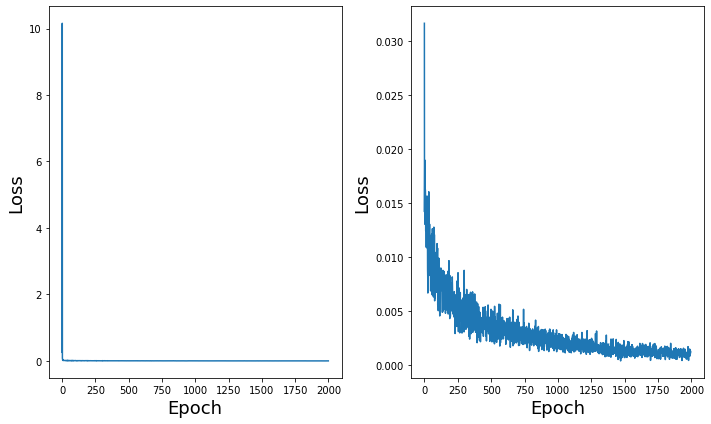

In [9]:
# Plot the loss function
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].plot(loss_hist)
axes[0].set_xlabel('Epoch', fontsize=label_font)
axes[0].set_ylabel('Loss', fontsize=label_font)
axes[1].plot(loss_hist[5:])
axes[1].set_xlabel('Epoch', fontsize=label_font)
axes[1].set_ylabel('Loss', fontsize=label_font)
fig.tight_layout();


In [10]:
# torch.save(classic_net.state_dict(), 'trained_N1_first-order_5000epochs.pt')
# torch.save(classic_net.state_dict(), 'trained_N2_first-order_5000epochs.pt')
# torch.save(classic_net.state_dict(), 'trained_N3_first-order_2000epochs.pt')
# torch.save(classic_net.state_dict(), 'trained_N4_all_tasks_5000epochs.pt')

# https://stackoverflow.com/questions/42703500/best-way-to-save-a-trained-model-in-pytorch
# https://pytorch.org/tutorials/beginner/saving_loading_models.html


0 0.0008856900967657566
0 8.153708768077195e-05


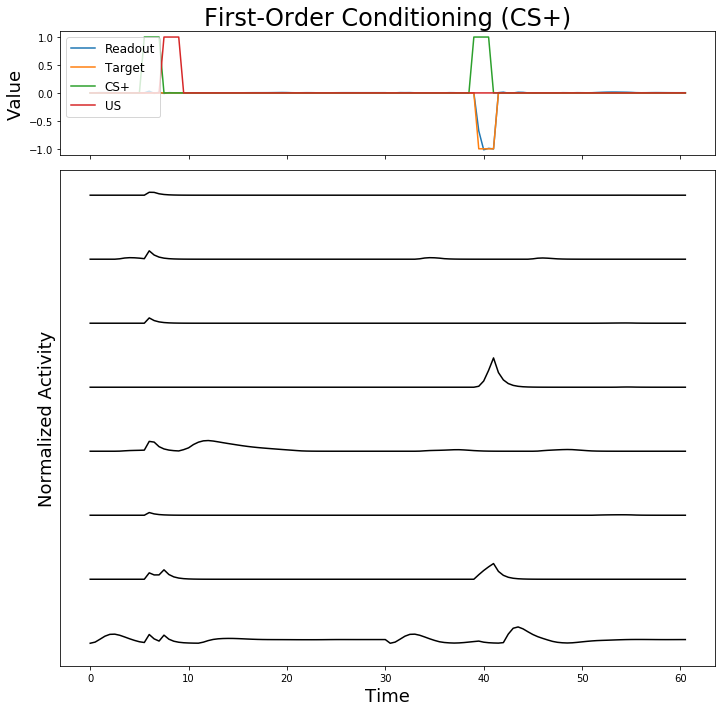

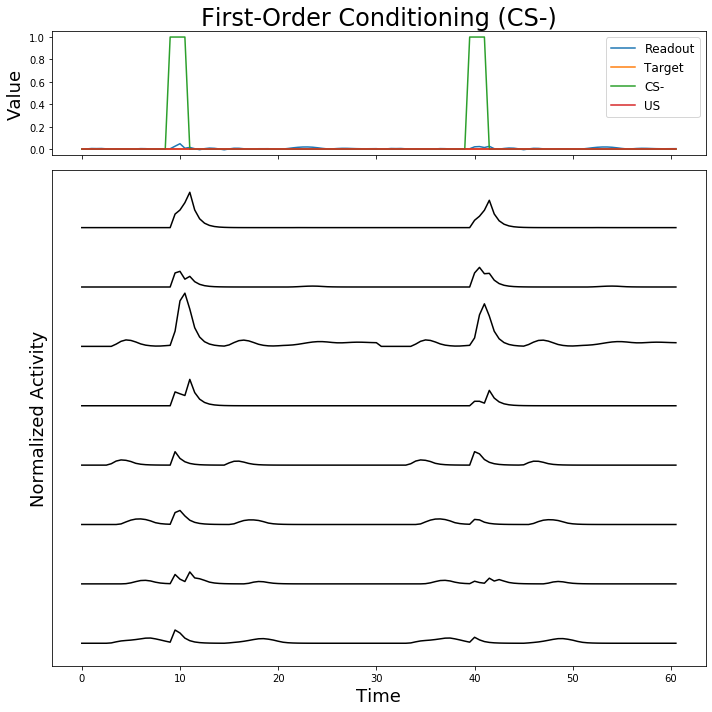

In [16]:
# Plot some results to compare to Fig 2A/B in paper
if not train_bool:
#     classic_net.load_state_dict(torch.load('trained_N1_first-order_5000epochs.pt'))
#     classic_net.load_state_dict(torch.load('trained_N2_first-order_5000epochs.pt'))
    classic_net.load_state_dict(torch.load('trained_N3_first-order_2000epochs.pt'))
#     classic_net.load_state_dict(torch.load('trained_N4_all_tasks_5000epochs.pt'))
    classic_net.eval()

if train_task == 'first-order':
    print_trial(classic_net, task1=train_task, task2='CS+')
    print_trial(classic_net, task1=train_task, task2='CS-')
elif train_task == 'all_tasks':
    print_trial(classic_net, task1=train_task, task2='extinct')
    print_trial(classic_net, task1=train_task, task2='CS2')
